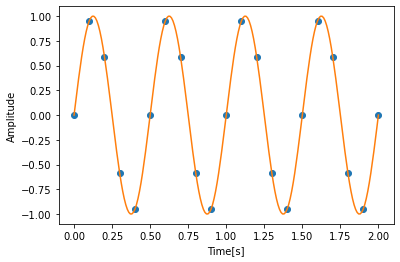

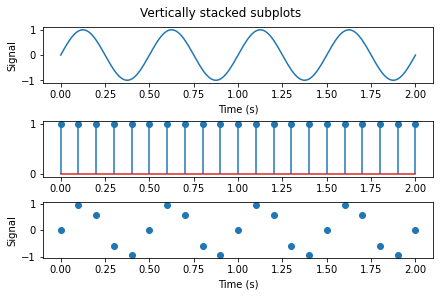

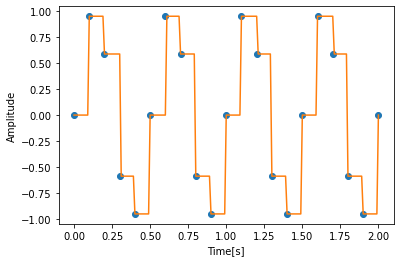

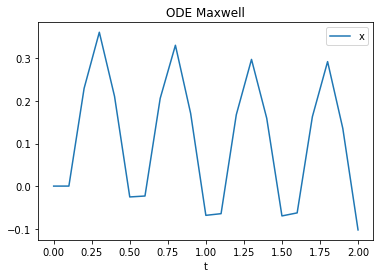

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

#define excitation varibales
f_s = 10               # Sample frequency
T_s = 1/f_s             # Sampling time
T = 2                  # Time interval of total test
f_I = 2                 # Excitation frequency
phi =0            # Signal phase
nCT = 10                # Oversampling points for continuous time plots

NDT=T*f_s               # Number of discrete points
NCT=T*f_s*nCT           # Number of cointinuous point
t_DT= np.arange(0, T+T_s, T_s)              # Discrete-time vector
t_CT= np.arange(0, T+(T_s/nCT), (T_s/nCT))  # Continuous-time vector

def sine (period):
    return np.sin(period)

u_DT=sine(2*np.pi*f_I*t_DT+phi)
u_CT=sine(2*np.pi*f_I*t_CT+phi)

plt.plot(t_DT, u_DT, "o", t_CT, u_CT, "-")
#ax3.suptitle('Continuous signal with sampled points')
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
plt.axis('tight')
plt.show()

fig2, (ax0, ax1,ax2) = plt.subplots(3, 1, layout='constrained')
fig2.suptitle('Vertically stacked subplots')
ax0.plot(t_CT, u_CT,'-')
ax1.stem(t_DT,np.ones(np.size(t_DT)))
ax2.plot(t_DT,u_DT,'o')

for ax in ax0,ax2:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Signal')

plt.show()

def DAC_0(u_discrete, sample_time, time_range):
    u_test = []
    for i in range(len(time_range)):
        x = int(time_range[i]//sample_time)
        u_test.append(u_discrete[x])
    return np.array(u_test)


# run the function
u_T = DAC_0(u_DT, T_s, t_CT)

# Alternative calculation of u_t, by use of scipy interpolation, kind is 0,2 and all odd numbers
u_interp=interp1d(t_DT,u_DT,kind=0)
u_t_interp = u_interp(t_CT)

plt.plot(t_DT, u_DT, "o", t_CT, u_t_interp, "-")
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
plt.axis('tight')
plt.show()

def gamma_dot(t):
    return u_interp(t)

# waarom moet je de waardes voor
# tau_dot=G*gamma_dot(t) -1/lambda *tau
def ODE_maxwell(t, tau, L,G):

    return G*gamma_dot(t) - tau/L

sol = solve_ivp(ODE_maxwell, [0, T], [0], args=(1.5, 2.5), t_eval=t_DT)

plt.plot(np.squeeze(t_DT), np.squeeze(sol.y))
plt.xlabel('t')
plt.legend(['x', 'y'], shadow=False)
plt.title('ODE Maxwell')
plt.show()

In [48]:
import math
import sys

def find_lcm(f_0, end_range):
    lcm = f_0
    for i in range(2, end_range + 1):
        lcm = math.lcm(lcm, f_0 * i)
    return lcm

def is_divisible(N, f_0, i):
    # Check if N divided by (f_0 * i) has no remainder
    return N % (f_0 * i) == 0

def recommend_N(f_0, N, end_range):
    recommended_N_larger = N
    recommended_N_smaller = N

    # Search for the closest suitable N in both directions
    while not (any(is_divisible(recommended_N_larger, f_0, i) for i in range(1, end_range + 1)) or any(is_divisible(recommended_N_smaller, f_0, i) for i in range(1, end_range + 1))):
        recommended_N_larger += 1
        recommended_N_smaller -= 1

    # Choose the closest suitable N
    if any(is_divisible(recommended_N_larger, f_0, i) for i in range(1, end_range + 1)) and any(is_divisible(recommended_N_smaller, f_0, i) for i in range(1, end_range + 1)):
        recommended_N = recommended_N_larger if abs(N - recommended_N_larger) < abs(N - recommended_N_smaller) else recommended_N_smaller
    elif any(is_divisible(recommended_N_larger, f_0, i) for i in range(1, end_range + 1)):
        recommended_N = recommended_N_larger
    else:
        recommended_N = recommended_N_smaller

    print(f"The recommended N for divisibility by ({f_0} * i) for i in the range 1 to {end_range} around {N} is {recommended_N}.")

    # Exit the program if N is not divisible by f_0
    if not any(is_divisible(N, f_0, i) for i in range(1, end_range + 1)):
        exit("Selected N is not divisible by f_0.")
    else:
        print(f"No recommendation needed. The selected value of N is already suitable.")

def recommend_N_function(f_0, N, end_range):
    return(recommend_N(f_0, N, end_range))

# Example usage:
f_0 = 10
N = 6005
end_range = 7

# Call the function with your chosen values
recommend_N_function(f_0, N, end_range)



The recommended N for divisibility by (10 * i) for i in the range 1 to 7 around 6005 is 6000.


In [234]:
import importlib
import rheosys

importlib.reload(rheosys)
f_0=6
N=2100
end_range=4


rheosys.window(f_0,N,end_range)

print("testen")



Nothing done.
testen


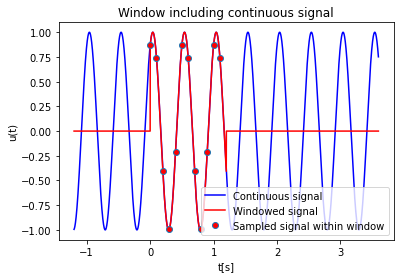

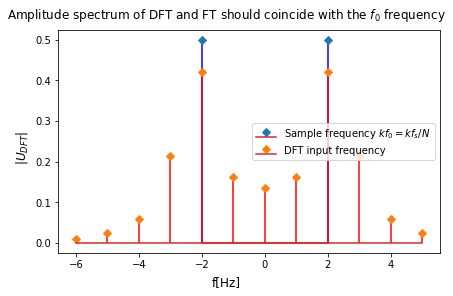

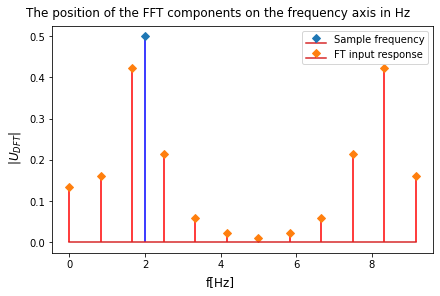

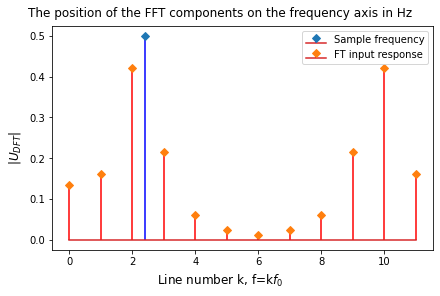

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.fft import fft,fftshift

def sine (period):
    return np.sin(period)

# To avoid aliasing and leakage, it is advised to determine the N (number of points in the window) and f_s (sampling frequency)
# From that calculate
# f_0=f_s/N = 1/T = 1/T_s*N
# line number k=N*f/f_s
# AVOID leakage: f_s/f_0 must be an integer

#define excitation varibales
f_s = 10                 # Sample frequency
N= 12                    # Number of points
f_0 = 2                 # Excitation frequency


NNW= 5e3           # No windowing number
TNW=NNW/f_s             # No windowing time length
phi= np.pi/3            # signal phase
T=N/f_s                 # Time length
Up=100                  # Upsampling for plots

tNW=np.arange((0-T*f_s),(3*T*f_s), (1/(f_s)))   # Time No windowing

uNW= sine(2*np.pi*f_0*tNW+phi)                  # Input signal No windowing
uW= uNW.copy()
uW[tNW<0]=0
uW[tNW>=T]=0                                    # Input signal Windowing

tNWUp=np.arange(-T,3*T,1/(f_s*Up))              # Plot time No Windowing
uNWUp=sine(2*np.pi*f_0*tNWUp+phi)                 # Plot input No Windowing
uWUp=uNWUp.copy()
uWUp[tNWUp<0]=0
uWUp[tNWUp>=T]=0                                # Plot input Windowing

td=np.arange(0,T,1/f_s)                     # Sampled Time
ud=sine(2*np.pi*f_0*td+phi)                 # Sampled input signal

Ud=(np.abs(fft(ud)))/N                      # DFT input signal
Udsplit=fftshift(Ud)                             # DFT input signal zero split
dB=-20*np.log(Udsplit)
fd=np.linspace(0,f_s,N,endpoint=False)                             # DFT frequency
fdsplit=np.linspace(-np.floor(N/2),-np.floor(N/2)+N,N,endpoint=False)    # DFT frequency zero split
Lines=np.arange(0,N,1)                      # Line numbers after DFT


plt.plot(tNWUp, uNWUp, "b",label=('Continuous signal'))
plt.plot(tNWUp, uWUp, 'r', label=('Windowed signal'))
plt.plot(td, ud,'o',markerfacecolor='red',label='Sampled signal within window')
plt.title('Window including continuous signal')
plt.xlabel('t[s]')
plt.ylabel('u(t)')
plt.legend()
plt.show()

fig0, (ax0) = plt.subplots(1, 1, layout='constrained')
ax0.stem([-f_0,f_0],[0.5,0.5],linefmt='blue', markerfmt='D',label='Sample frequency $kf_0=kf_s/N$')
ax0.stem(fdsplit,Udsplit,linefmt='red', markerfmt='D',label='DFT input frequency')
fig0.suptitle('Amplitude spectrum of DFT and FT should coincide with the $f_0$ frequency')
fig0.supxlabel('f[Hz]')
fig0.supylabel('$|U_{DFT}|$')
ax0.legend()

fig1, (ax1) = plt.subplots(1, 1, layout='constrained')
fig1.suptitle('Vertically stacked subplots')
ax1.stem(f_0,0.5,linefmt='blue', markerfmt='D',label='Sample frequency')
ax1.stem(fd,Ud,linefmt='red', markerfmt='D',label='FT input response')
fig1.suptitle('The position of the FFT components on the frequency axis in Hz ')
fig1.supxlabel('f[Hz]')
fig1.supylabel('$|U_{DFT}|$')
ax1.legend()

fig2, (ax2) = plt.subplots(1, 1, layout='constrained')
fig2.suptitle('Vertically stacked subplots')
ax2.stem(f_0*T,0.5,linefmt='blue', markerfmt='D',label='Sample frequency')
ax2.stem(Lines,Ud,linefmt='red', markerfmt='D',label='FT input response')
fig2.suptitle('The position of the FFT components on the frequency axis in Hz')
fig2.supxlabel('Line number k, f=k$f_0$')
fig2.supylabel('$|U_{DFT}|$')
ax2.legend()



plt.show()


min(t_DT): 0.0
max(t_DT): 0.99
min(t_CT): 0.0
max(t_CT): 0.9999


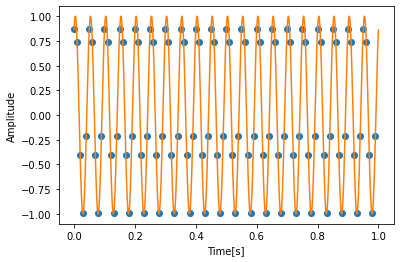

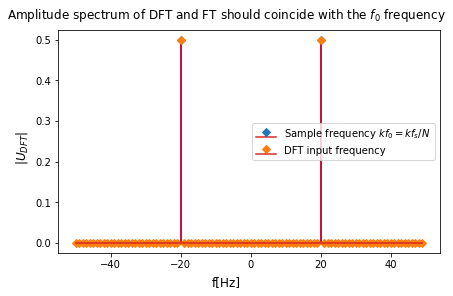

ValueError: A value in x_new is above the interpolation range.

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.fft import fft,fftshift

def sine (period):
    return np.sin(period)

# To avoid aliasing and leakage, it is advised to determine the N (number of points in the window) and f_s (sampling frequency)
# From that calculate
# f_0=f_s/N = 1/T = 1/T_s*N
# line number k=N*f/f_s
# AVOID leakage: f_s/f_0 must be an integer

#define excitation varibales
f_s = 100                 # Sample frequency
N= 100                    # Number of points
f_0 = 20                 # Excitation frequency

phi= np.pi/3            # signal phase
Up=100                  # Upsampling for plots

# Calculation of time window
T=N/f_s                 # Time length
T_s = 1/f_s             # Sampling time
t_DT= np.arange(0, T,1/f_s)              # Discrete-time vector
t_CT= np.arange(0, T, 1/(f_s*Up))  # Continuous-time vector

u_DT=sine(2*np.pi*f_0*t_DT+phi)
u_CT=sine(2*np.pi*f_0*t_CT+phi)
print("min(t_DT):", min(t_DT))
print("max(t_DT):", max(t_DT))
print("min(t_CT):", min(t_CT))
print("max(t_CT):", max(t_CT))

plt.plot(t_DT, u_DT, "o", t_CT, u_CT, "-")
#ax3.suptitle('Continuous signal with sampled points')
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
plt.axis('tight')
plt.show()

### Creation of the
Ud=(np.abs(fft(u_DT)))/N                         # DFT input signal
Udsplit=fftshift(Ud)                             # DFT input signal zero split
dB=-20*np.log(Udsplit)
fd=np.linspace(0,f_s,N,endpoint=False)                             # DFT frequency
fdsplit=np.linspace(-np.floor(N/2),-np.floor(N/2)+N,N,endpoint=False)    # DFT frequency zero split
Lines=np.arange(0,N,1)                      # Line numbers after DFT

fig0, (ax0) = plt.subplots(1, 1, layout='constrained')
ax0.stem([-f_0,f_0],[0.5,0.5],linefmt='blue', markerfmt='D',label='Sample frequency $kf_0=kf_s/N$')
ax0.stem(fdsplit,Udsplit,linefmt='red', markerfmt='D',label='DFT input frequency')
fig0.suptitle('Amplitude spectrum of DFT and FT should coincide with the $f_0$ frequency')
fig0.supxlabel('f[Hz]')
fig0.supylabel('$|U_{DFT}|$')
ax0.legend()
plt.show()

# Alternative calculation of u_t, by use of scipy interpolation, kind is 0,2 and all odd numbers
u_interp=interp1d(t_DT,u_DT,kind=0)
u_t_interp = u_interp(t_CT)

plt.plot(t_DT, u_DT, "o", t_CT, u_t_interp, "-")
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
plt.axis('tight')
plt.show()

def gamma_dot(t):
    return u_interp(t)

# tau_dot=G*gamma_dot(t) -1/lambda *tau
def ODE_maxwell(t, tau, L,G):
    #L,G=args
    return G*gamma_dot(t) - tau/L

sol = solve_ivp(ODE_maxwell, [0, T], [0], args=(1.5, 2.5), t_eval=t_DT)

plt.plot(np.squeeze(t_DT), np.squeeze(sol.y))
plt.xlabel('t')
plt.legend(['x', 'y'], shadow=False)
plt.title('ODE Maxwell')
plt.show()